<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=5>
    Multi-Layer Perceptron (MLP)

# Description

**In this notebook we'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive.
To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

# Importing libraries, modules and Dataset.

In [100]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

torch.manual_seed(1)

In [2]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_valid.data"
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/dorothea_valid.labels"
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.data"
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.labels"
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_test.data"
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea.param"

--2023-05-27 15:50:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_valid.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1871651 (1.8M) [application/x-httpd-php]
Saving to: ‘dorothea_valid.data’

dorothea_valid.data 100%[===================>]   1.78M  1.65MB/s    in 1.1s    

2023-05-27 15:50:53 (1.65 MB/s) - ‘dorothea_valid.data’ saved [1871651/1871651]

--2023-05-27 15:50:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/dorothea_valid.labels
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016 [application/x-httpd-php]
Saving to: ‘dorothea_valid.labels’

dorothea_valid.labe 100%[======

In [202]:
def zero_one(data):
  for i, e in enumerate(data):
    if e == -1:
      data[i] = 0

X_train = np.zeros((800, 100000))
X_test = np.zeros((350, 100000))
with open('./dorothea_train.data', 'r') as f:
  lines = f.readlines()
  for i, l in enumerate(lines):
    for j in l.strip().split(' '):
      X_train[i, int(j)-1] = 1
with open('./dorothea_valid.data', 'r') as f:
  lines = f.readlines()
  for i, l in enumerate(lines):
    for j in l.strip().split(' '):
      X_test[i, int(j)-1] = 1

y_train = pd.read_csv("./dorothea_train.labels", header=None)[0]
y_test = pd.read_csv("./dorothea_valid.labels", header=None)[0]
zero_one(y_train)
zero_one(y_test)

## Normalizing

In [203]:
scaler = StandardScaler()
transformer = scaler.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

## Dimensionality Reduction

In [131]:
pca = PCA(n_components=10)
transformer = pca.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# Defining Model

In [197]:
class ClassifierModel(nn.Module):
    def __init__(self, in_dim):
      super().__init__()

      self.layer_1 = nn.Linear(in_dim, 256) 
      self.layer_2 = nn.Linear(256, 32)
      self.layer_out = nn.Linear(32, 1) 
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.batchnorm1 = nn.BatchNorm1d(256)
      self.batchnorm2 = nn.BatchNorm1d(32)

    def forward(self, x):
      x = self.dropout(x)
      x = self.relu(self.layer_1(x))
      x = self.batchnorm1(x)
      x = self.dropout(x)
      x = self.relu(self.layer_2(x))
      x = self.batchnorm2(x)
      x = self.dropout(x)
      x = self.layer_out(x)

      return x

In [7]:
class TrainDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]
  
  def __len__(self):
    return self.length

class TestDataset(Dataset):
  def __init__(self, x):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self, idx):
    return self.x[idx]
  
  def __len__(self):
    return self.length

# Train the model

In [9]:
def train(model, optimizer, train_loader, device):
  model.train()
  train_loss = 0
  bce_l = nn.BCEWithLogitsLoss()
  for batch_idx, (data, y_test) in enumerate(train_loader):
    data, y_test = data.to(device), y_test.to(device)
    optimizer.zero_grad()

    y_pred = model(data)

    loss = bce_l(y_pred, y_test.unsqueeze(1))
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  average_loss = train_loss / len(train_loader)
  
  return average_loss

In [209]:
def test(model, test_loader, device):
  model.eval()
  y_pred_list = []
  test_loss = 0
  bce_l = nn.BCEWithLogitsLoss()
  with torch.no_grad():
    for X_batch, y_test in test_loader:
      X_batch, y_test = X_batch.to(device), y_test.to(device)
      y_pred = model(X_batch)
      loss = bce_l(y_pred, y_test.unsqueeze(1))
      y_pred = torch.sigmoid(y_pred)
      y_pred_r = torch.round(y_pred)
      y_pred_list.append(y_pred_r.cpu().numpy())

      test_loss += loss.item()

  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  average_loss = test_loss / len(test_loader)
  return average_loss, y_pred_list

In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

in_dim = 10
model = ClassifierModel(in_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_set = TrainDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = TrainDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

epochs = 28

train_loss = []
test_loss = []
y_pred_list = []
for epoch in range(1, epochs+1):
  train_l = train(model, optimizer, train_loader, device)
  test_l, y_pred = test(model, test_loader, device)
  y_pred_list.append(y_pred)
  train_loss.append(train_l)
  test_loss.append(test_l)

  if epoch % 2 == 0:
    print('====> Epoch: {} Train-loss: {:.5f} | Test-loss: {:.5f}'.format(epoch, train_l, test_l))

cuda
====> Epoch: 2 Train-loss: 0.66331 | Test-loss: 0.64500
====> Epoch: 4 Train-loss: 0.57210 | Test-loss: 0.62384
====> Epoch: 6 Train-loss: 0.55301 | Test-loss: 0.61468
====> Epoch: 8 Train-loss: 0.50438 | Test-loss: 0.59362
====> Epoch: 10 Train-loss: 0.47702 | Test-loss: 0.58273
====> Epoch: 12 Train-loss: 0.45469 | Test-loss: 0.58009
====> Epoch: 14 Train-loss: 0.43995 | Test-loss: 0.56366
====> Epoch: 16 Train-loss: 0.40344 | Test-loss: 0.54374
====> Epoch: 18 Train-loss: 0.37210 | Test-loss: 0.52430
====> Epoch: 20 Train-loss: 0.36862 | Test-loss: 0.49295
====> Epoch: 22 Train-loss: 0.35752 | Test-loss: 0.49965
====> Epoch: 24 Train-loss: 0.33731 | Test-loss: 0.47808
====> Epoch: 26 Train-loss: 0.32509 | Test-loss: 0.45919
====> Epoch: 28 Train-loss: 0.29964 | Test-loss: 0.44515


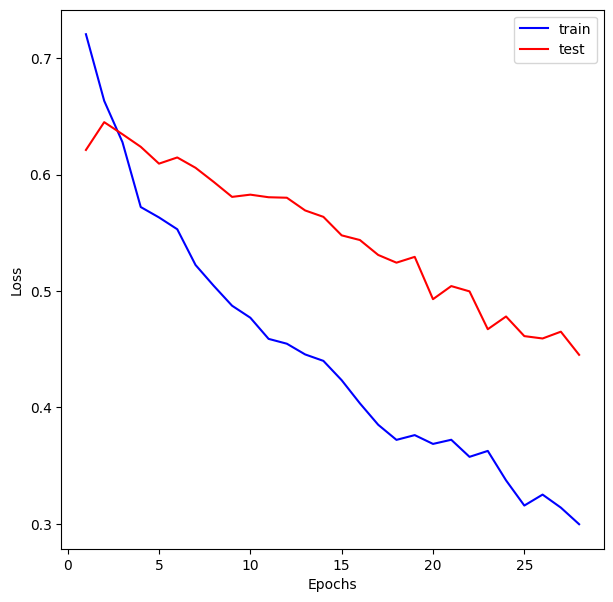

In [211]:
plt.subplots(1, figsize=(7,7))
plt.plot(np.linspace(1, epochs, epochs), train_loss, label="train", color="blue")
plt.plot(np.linspace(1, epochs, epochs), test_loss, label="test", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

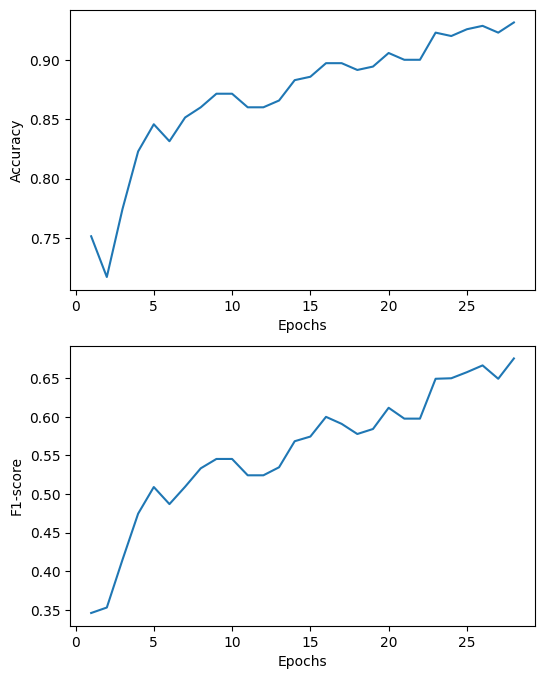

In [212]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
acc = [accuracy_score(y_test, y) for y in y_pred_list]
f1 = [f1_score(y_test, y) for y in y_pred_list]
axes[0].plot(np.linspace(1, epochs, epochs), acc)
axes[0].set_ylabel("Accuracy")
axes[1].plot(np.linspace(1, epochs, epochs), f1)
axes[1].set_ylabel("F1-score")
for ax in axes:
  ax.set_xlabel("Epochs")

plt.show()

# Testing

In [213]:
def test(model, test_loader, device):
  model.eval()
  y_pred_list = []
  with torch.no_grad():
    for X_batch, _ in test_loader:
      X_batch = X_batch.to(device)
      y_pred = model(X_batch)
      y_pred = torch.sigmoid(y_pred)
      y_pred_r = torch.round(y_pred)
      y_pred_list.append(y_pred_r.cpu().numpy())

  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  return y_pred_list

y_pred = test(model, test_loader, device)

print("F1-score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_pred))

F1-score: 0.6756756756756757
Accuracy: 0.9314285714285714
ROC_AUC: 0.8439128816083395


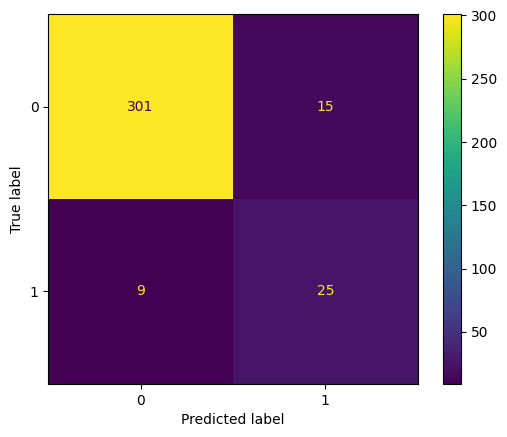

In [214]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Saving Model

In [216]:
torch.save(model.state_dict(), './mlp_saved.pt')